In [1]:
# Import libraries
import pandas as pd
from sodapy import Socrata
from dotenv import load_dotenv
import os
import pyvin
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import difflib
tqdm.pandas()

In [2]:
def run_client(client_url):
    '''
    Input:
        - N/A
    Output:
        - Client data for New York State API
    '''
    #Load enviroment file
    load_dotenv()
    
    # Login to NYS data with enviornment data
    client = Socrata(client_url,
                 os.getenv('nys_dmv_app_token'),
                 username = os.getenv('nys_dmv_api_key_id'),
                 password = os.getenv('nys_dmv_secret'))
    return client

def load_dmv_api(client_url):
    '''
    Input:
        - N/A
    Output:
        - Dataframe with all vehicle registrations in New York that have not expired two years ago
            - The data frame includes only vehicles from New York City that are electric
    '''
    
    # Set up endpoint
    endpoint = 'w4pv-hbkt'
    
    # Get client information
    client = run_client(client_url)
    
    # Get total number of records in api
    query_count = "SELECT COUNT(*)"
    NUM_RECORDS = 1000
    # NUM_RECORDS = int(client.get(endpoint, query = query_count)[0]['COUNT'])
    
    # Set up query for api. Select only only vehicles from New York City that are electric
    query = f"""
        SELECT vin, county, zip
        WHERE record_type = 'VEH'
        AND county in ('NEW YORK')
        AND fuel_type = 'ELECTRIC'
        LIMIT {NUM_RECORDS}
    """
    #
    
    # Pull results from DMV registration that are vehicles
    results = client.get(endpoint, query=query)
    
    # Change results into dataframe
    return pd.DataFrame.from_records(results)

def load_zip_api(client_url):
    '''
    Input:
        - N/A
    Output:
        - Dataframe with NYC zipcodes 
    '''
    
    # Set up endpoint
    endpoint = 'pri4-ifjk'
    
    # Get client information
    client = run_client(client_url)
    
    # Get total number of records in api
    query_count = "SELECT COUNT(*)"
    NUM_RECORDS = int(client.get(endpoint, query = query_count)[0]['COUNT'])
    
    # Set up query for api. Select only only vehicles from New York City that are electric
    query = f"""
        SELECT *
        LIMIT {NUM_RECORDS}
    """
    #
    
    # Pull results from DMV registration that are vehicles
    results = client.get(endpoint, query=query)
    
    # Change results into dataframe
    return pd.DataFrame.from_records(results)

In [3]:
# Load dataset with vin numbers of NYS registered vehicles
df_dmv = load_dmv_api('data.ny.gov')

# Get only vins with the correct number of digits for a person vehicle
df_dmv = df_dmv.loc[df_dmv['vin'].str.len() == 17].copy()

# Drop nan
df_dmv.dropna(inplace = True)

In [4]:
# Change vin numbers to models
df_dmv['model'] = df_dmv['vin'].progress_apply(lambda x: pyvin.VIN(x, error_handling=pyvin.PASS).Model)

  0%|          | 0/996 [00:00<?, ?it/s]

In [5]:
# Drop values if model could not be calculated
df_dmv.dropna(subset=['model'], inplace = True)

In [6]:
# Load emission & range data for epa registered vehicles
df_veh_range = pd.read_csv('https://www.fueleconomy.gov/feg/epadata/vehicles.csv', low_memory=False)

# Change values to float
def func_to_numeric(x):
    return pd.to_numeric(x, errors = 'coerce')
    
df_veh_range[['range','rangeCity','rangeCityA','rangeHwy','rangeHwyA','rangeA']] = df_veh_range[['range','rangeCity','rangeCityA','rangeHwy','rangeHwyA','rangeA']].apply(func_to_numeric)

# Get mean of vehicle ranges
df_veh_range['max_range'] = df_veh_range[['range','rangeCity','rangeCityA','rangeHwy','rangeHwyA','rangeA']].max(axis = 1)

# Get only the model and vehicle range
df_veh_range = df_veh_range[['model','max_range']]

# Drop vehicles without type 2 fuel range
df_veh_range.dropna(subset=['max_range'], inplace = True)

# Group model duplicates and take the max of the duplicates
df_veh_range = df_veh_range.groupby('model').max().reset_index()

# Sort ranges by model names
df_veh_range.sort_values(by = ['model'], inplace = True)

In [7]:
df_veh_range[df_veh_range['model'] == 'Model Y Long Range AWD']

save_df = df_dmv

In [8]:
# Convert team name in df2 to team name it most closely matches in df1
df_dmv['model'] = df_dmv['model'].apply(lambda x: difflib.get_close_matches(x, df_veh_range['model'], n=1))

df_dmv['model']
# Merge NYS values with model range
# test = df_dmv.merge(df_veh_range, how='left', on='model')

# test

1             []
2             []
3             []
4             []
5             []
         ...    
995    [Model X]
996    [Model X]
997    [Model X]
998    [Model X]
999    [Model X]
Name: model, Length: 996, dtype: object

<AxesSubplot: >

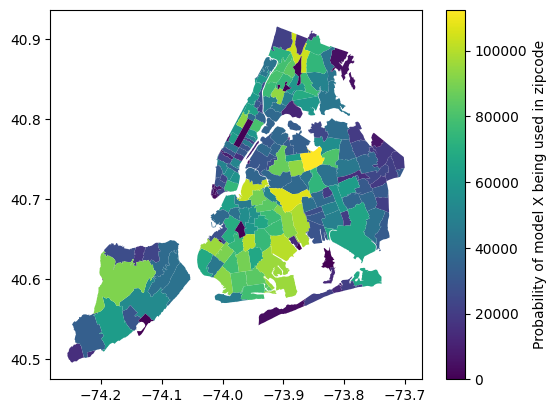

In [9]:
# Load zipcode data
zip_df = load_zip_api('data.cityofnewyork.us')

# Change geometry into shaply object
zip_df['geometry'] = zip_df['the_geom'].apply(lambda x: shape(x))

# Convert dataframe into geopandas dataframe
gdf_zip = gpd.GeoDataFrame(zip_df, geometry = 'geometry', crs = 'EPSG:4326')
gdf_zip['pop_est'] = gdf_zip['pop_est'].apply(lambda x: float(x))

gdf_zip.plot(column = 'pop_est', 
             legend = True,
             legend_kwds = {
                            'label': "Probability of model X being used in zipcode"
                           }
            )